In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
from sklearn.multioutput import MultiOutputClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier

from gensim.models import Word2Vec

In [2]:
'''
Read in train data
'''

df = pd.read_csv('data/train.csv/train.csv')
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [3]:
'''
Show how much of each label there are
'''

total = df.shape[0]
print('rows:', df.shape[0])
# toxic,severe_toxic,obscene,threat,insult,identity_hate
print('# toxic comments:', df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)].shape[0])

print('% toxic:', 1-df[(df['toxic'] == 1)].shape[0]/total)
print('% severe_toxic:', 1-df[(df['severe_toxic'] == 1)].shape[0]/total)
print('% obscene:', 1-df[(df['obscene'] == 1)].shape[0]/total)
print('% threat:', 1-df[(df['threat'] == 1)].shape[0]/total)
print('% insult:', 1-df[(df['insult'] == 1)].shape[0]/total)
print('% identity_hate:', 1-df[(df['identity_hate'] == 1)].shape[0]/total)

rows: 159571
# toxic comments: 16225
% toxic: 0.9041555169799024
% severe_toxic: 0.9900044494300343
% obscene: 0.947051782592075
% threat: 0.9970044682304429
% insult: 0.9506363938309592
% identity_hate: 0.9911951419744189


#### Visualization (data)

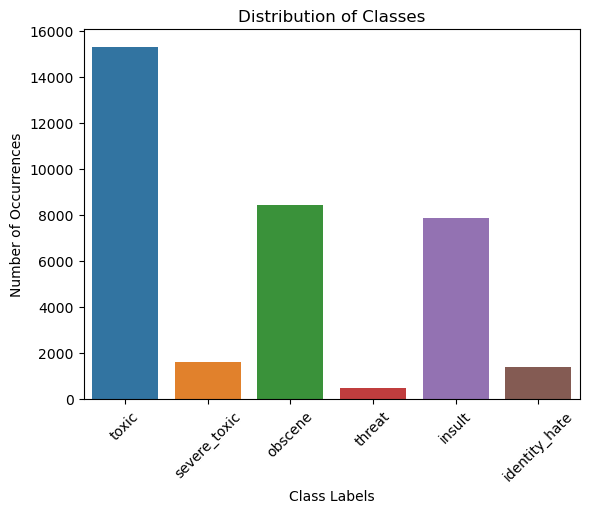

In [4]:
''' 
Show distribution of classes
'''

label_counts = df[label_columns].sum()

sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Classes')
plt.ylabel('Number of Occurrences')
plt.xlabel('Class Labels')
plt.xticks(rotation=45)
plt.show()

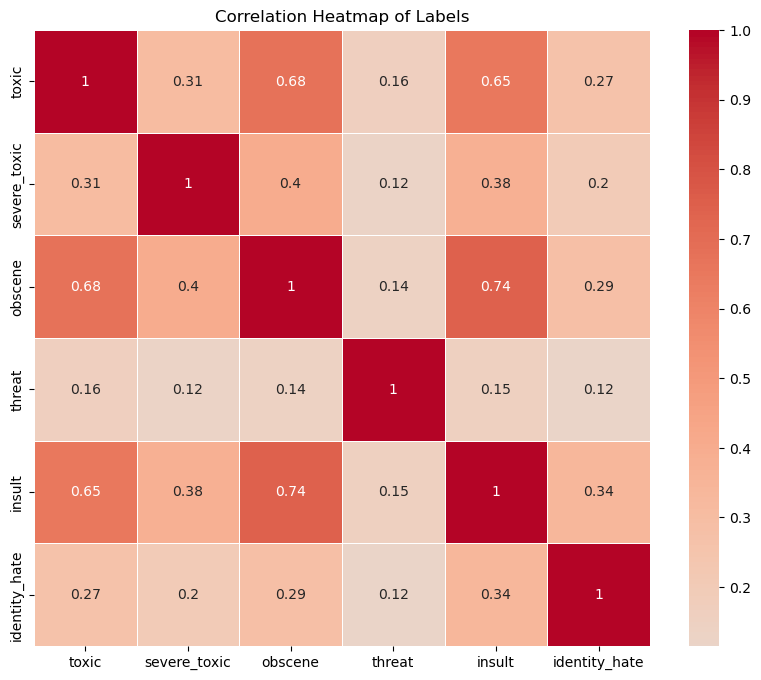

In [5]:
''' 
Show Correlation Heatmap
'''
# Compute the correlation matrix
corr = df[label_columns].corr()

# Generate a mask for the upper triangle (if u want)
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
# If you want to add a mask, add the following in sns.heatmap: 'mask=mask'
sns.heatmap(corr, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, annot=True)

plt.title('Correlation Heatmap of Labels')
plt.show()

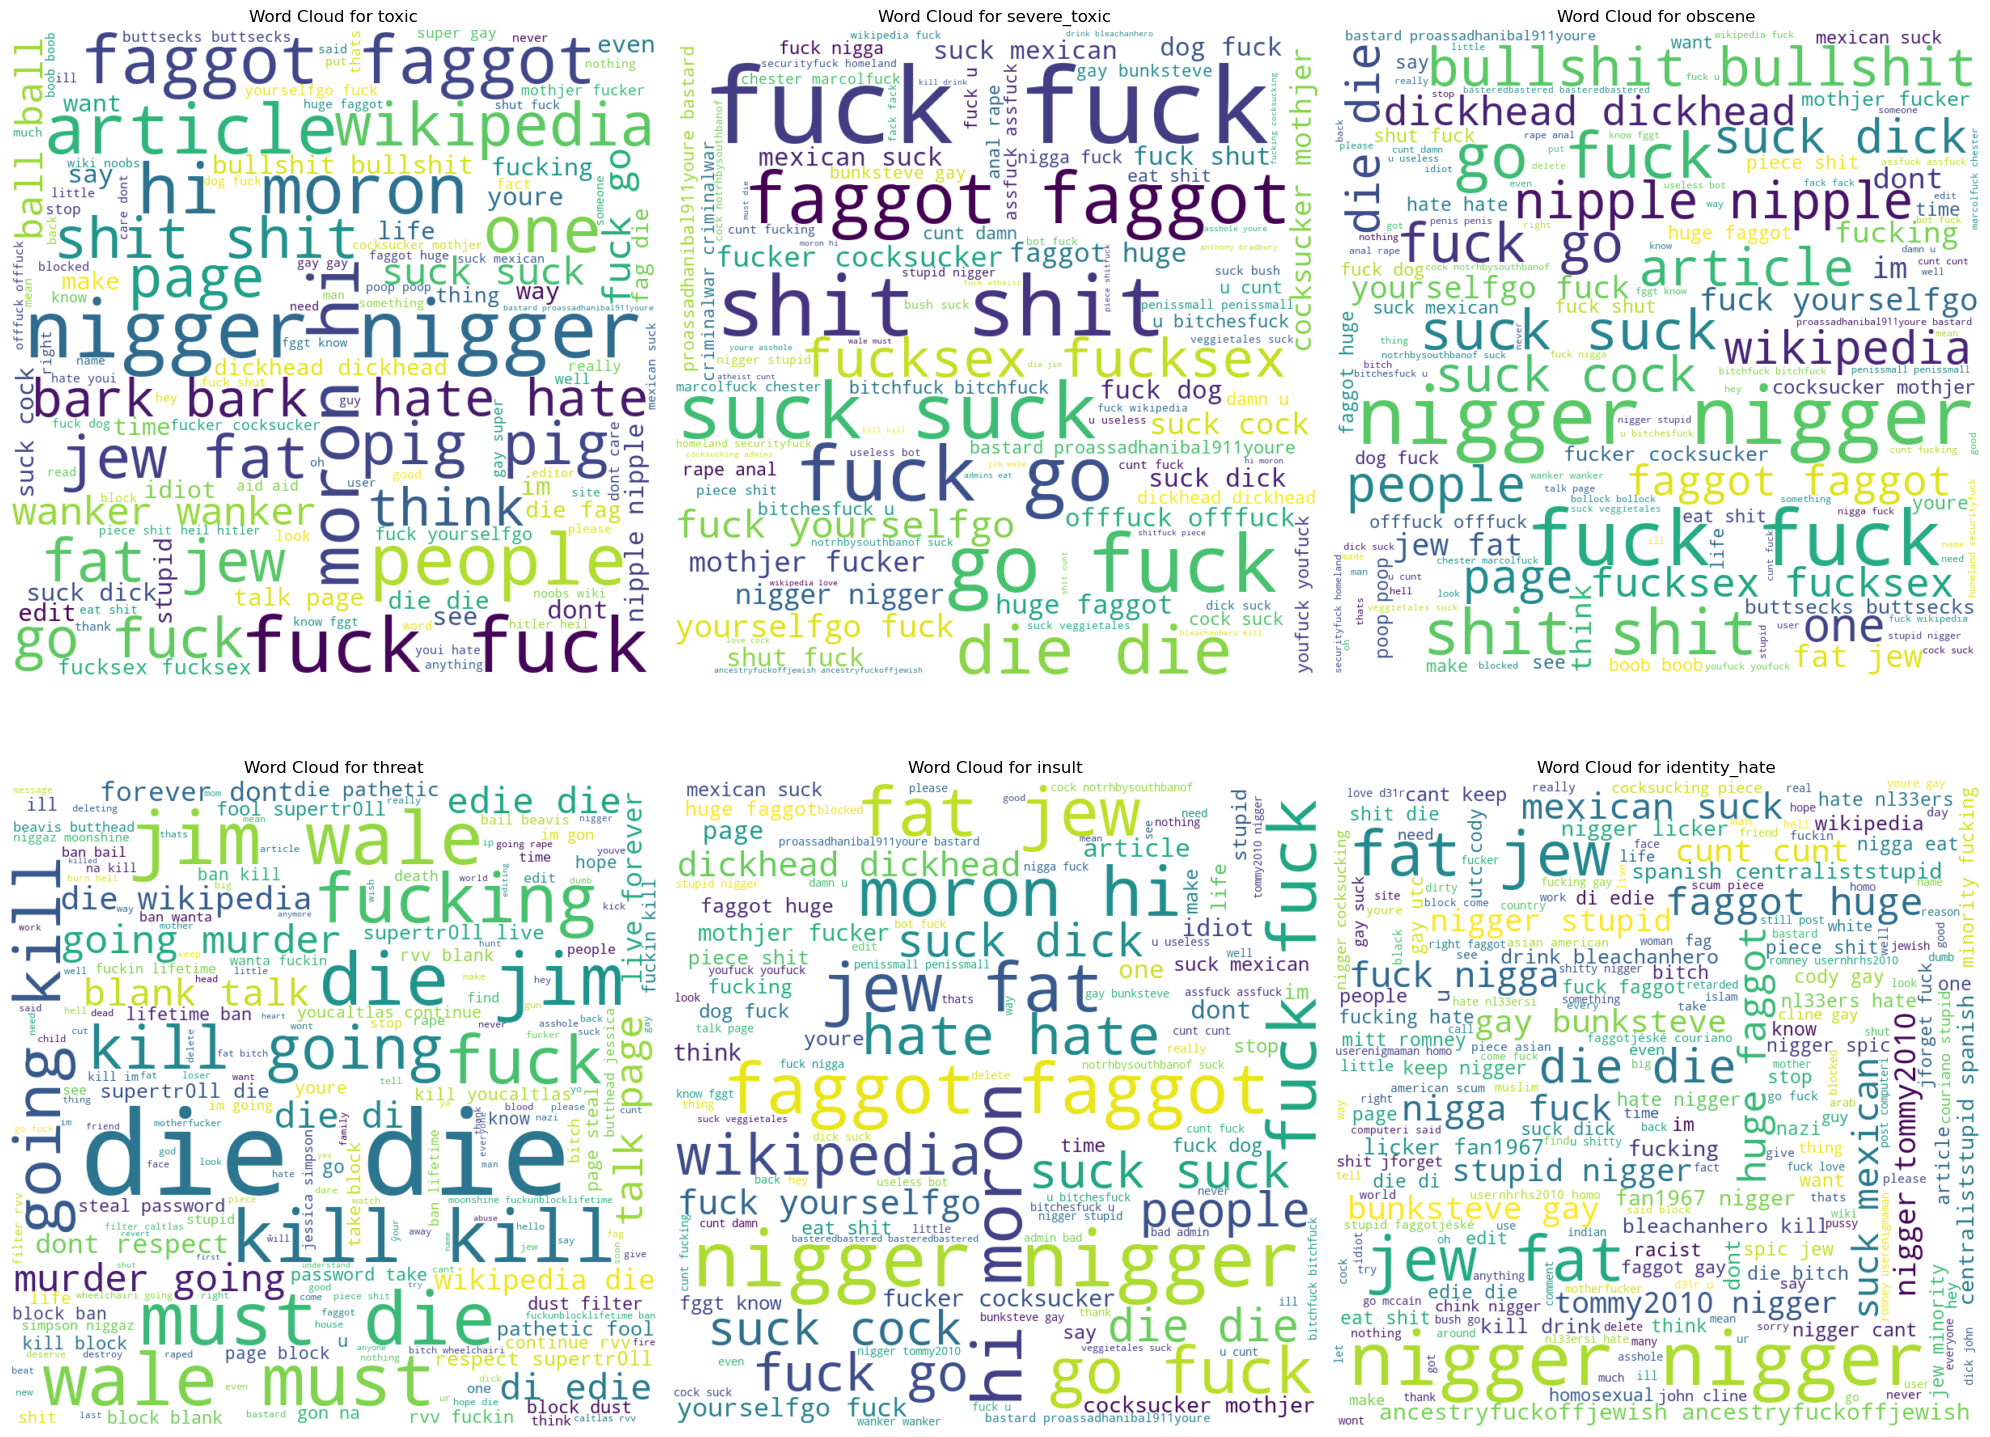

In [24]:
''' 
Wordcloud for each label
'''
# List of labels
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Number of rows and columns for subplots
n_rows = 2
n_cols = 3

# Set up the matplotlib figure
plt.figure(figsize=(20, 8 * n_rows))

for i, label in enumerate(label_columns, 1):
    # Combine all text from the rows where label is 1
    text = ' '.join(df[df[label] == 1]['comment_text'])
    # Generate word cloud
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          min_font_size = 10).generate(text)
    # Plot using subplot
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label}')
    plt.axis("off")

plt.tight_layout()
plt.show()

### Preprocessing (LogReg)

In [7]:
''' 
resampling - undersampling
'''

# Count the number of labels per row (you might already have this)
df['label_count'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)

# Separate the minority and majority instances
minority_df = df[df['label_count'] > 0]     # s = 16k
majority_df = df[df['label_count'] == 0]

# Under-sample the majority dataframe
sampled_majority_df = majority_df.sample(n=len(minority_df))

# Combine back the minority and downsampled majority instances
balanced_df = pd.concat([minority_df, sampled_majority_df])

# Now balanced_df is the under-sampled DataFrame
df = balanced_df
print(df.shape[0])

32450


In [8]:
''' 
Additional Functions
'''
def document_vector(word2vec_model, doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    else:
        return np.mean(word2vec_model.wv[doc], axis=0)

In [9]:
'''
Basic Data Cleaning and Preprocessing
NOTE:
run time: 30 to 40 sec
Tokenization: turn text into tokens
Lemmatization: extracting a word's base form (ex: running -> run)
'''


# remove line breaks and special characters
df['comment_text'] = df['comment_text'].apply(lambda x: re.sub(r'\n', ' ', x))
df['comment_text'] = df['comment_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['comment_text'] = df['comment_text'].apply(lambda x: x.replace(u'\u00A0', ' '))
print(df['comment_text'][6])

# Convert to lowercase
df['comment_text'] = df['comment_text'].apply(lambda x: x.lower())
print(df['comment_text'][6])

# Tokenization
df['comment_text'] = df['comment_text'].apply(lambda x: nltk.word_tokenize(x))
print(df['comment_text'][6])

# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['comment_text'] = df['comment_text'].apply(lambda x: [word for word in x if word not in stop_words])
print(df['comment_text'][6])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['comment_text'] = df['comment_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
print(df['comment_text'][6])

# Create Vectorizer after tokenization
vectorizers = []
word2vec_model = Word2Vec(df['comment_text'], vector_size=300, window=5, min_count=1, workers=4)
vectorizers.append(word2vec_model)

tfidf_vectorizer = TfidfVectorizer()
vectorizers.append(tfidf_vectorizer)

# Rejoin tokens into strings (for context for tfidf)
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join(x))
print(df['comment_text'][6])

# Create Vectorizer and transform data
v = 0
if v == 0:
    # Vectorize each document
    vectorized_data = np.array([document_vector(word2vec_model, doc) for doc in df['comment_text']])
elif v == 1:
    vectorized_data = tfidf_vectorizer.fit_transform(df['comment_text'])
print(vectorized_data)

# Example output
df['comment_text'].head()

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
cocksucker before you piss around on my work
['cocksucker', 'before', 'you', 'piss', 'around', 'on', 'my', 'work']
['cocksucker', 'piss', 'around', 'work']
['cocksucker', 'piss', 'around', 'work']
cocksucker piss around work
[[0.30351797 0.37435925 0.10966525 ... 0.77582765 0.26172951 0.25149   ]
 [0.25018349 0.32507327 0.07161029 ... 0.66274714 0.24845901 0.20808351]
 [0.2332125  0.33165324 0.05830342 ... 0.59299678 0.23477538 0.15834445]
 ...
 [0.23471539 0.33071738 0.07405388 ... 0.64411408 0.24363865 0.19696756]
 [0.25670063 0.37018794 0.08049992 ... 0.68275142 0.27502087 0.19565038]
 [0.24853541 0.34746975 0.08699139 ... 0.68592882 0.26465374 0.21036902]]


6                           cocksucker piss around work
12    hey talk exclusive group wp talibanswho good d...
16         bye dont look come think comming back tosser
42    gay antisemmitian archangel white tiger meow g...
43                            fuck filthy mother as dry
Name: comment_text, dtype: object

In [20]:
''' 
Model Implementation: Logistic Regression
'''
X = vectorized_data
y = df[label_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a dictionary to hold your models
logistic_models = {}

# Loop over each label
for label in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    # Create a Logistic Regression model
    lr = LogisticRegression(solver='saga', C=1)

    # Train the model
    lr.fit(X_train, y_train[label])

    # Store the model
    logistic_models[label] = lr

c:\Users\hrita\anaconda3\envs\dirac\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hrita\anaconda3\envs\dirac\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hrita\anaconda3\envs\dirac\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hrita\anaconda3\envs\dirac\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hrita\anaconda3\envs\dirac\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hrita\anaconda3\envs\dirac\Lib\site-packages\s

In [23]:
y_pred = pd.DataFrame(index=y_test.index)

for label in logistic_models:
    y_pred[label] = logistic_models[label].predict(X_test)

# Evaluate each model
for label in logistic_models:
    print(f"Classification Report for {label}:")
    print(classification_report(y_test[label], y_pred[label]))
    
accuracy = accuracy_score(y_test.values, y_pred.values)
print(type(y_test))
for y in range(len(y_test)):
    if any(y_test.iloc[y].values != y_pred.iloc[y].values):
        print(y_test.iloc[y].values, y_pred.iloc[y].values, '\n')
print("Accuracy:", accuracy)    

Classification Report for toxic:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      3462
           1       0.71      0.52      0.60      3028

    accuracy                           0.68      6490
   macro avg       0.68      0.67      0.66      6490
weighted avg       0.68      0.68      0.67      6490

Classification Report for severe_toxic:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6167
           1       0.41      0.07      0.12       323

    accuracy                           0.95      6490
   macro avg       0.68      0.53      0.55      6490
weighted avg       0.93      0.95      0.93      6490

Classification Report for obscene:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      4798
           1       0.80      0.29      0.43      1692

    accuracy                           0.80      6490
   macro avg       0

c:\Users\hrita\anaconda3\envs\dirac\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hrita\anaconda3\envs\dirac\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hrita\anaconda3\envs\dirac\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1 0 0 0 0 0] 

[1 0 0 0 0 0] [0 0 0 0 0 0] 

[1 0 1 0 1 1] [1 1 1 0 1 0] 

[1 0 1 0 0 1] [1 0 1 0 0 0] 

[1 0 0 0 0 0] [0 0 0 0 0 0] 

[1 0 1 0 1 1] [1 0 0 0 0 0] 

[1 0 0 0 1 0] [0 0 0 0 0 0] 

[1 0 0 0 1 0] [0 0 0 0 0 0] 

[1 0 0 0 0 0] [0 0 0 0 0 0] 

[1 0 1 0 0 0] [0 0 0 0 0 0] 

[1 1 1 0 1 0] [1 0 0 0 0 0] 

[1 0 0 0 1 0] [0 0 0 0 0 0] 

[1 0 0 0 1 0] [0 0 0 0 0 0] 

[0 0 0 0 0 0] [1 0 0 0 0 0] 

[1 0 0 0 1 0] [0 0 0 0 0 0] 

[1 0 0 0 0 0] [0 0 0 0 0 0] 

[0 0 0 0 1 0] [0 0 0 0 0 0] 

[1 1 1 0 1 0] [0 0 0 0 0 0] 

[1 0 0 0 0 0] [0 0 0 0 0 0] 

[1 0 0 0 0 0] [0 0 0 0 0 0] 

[1 0 0 0 0 0] [0 0 0 0 0 0] 

[1 0 1 0 1 1] [1 0 1 0 0 0] 

[1 1 1 0 1 0] [1 0 1 0 1 0] 

[1 0 1 0 1 1] [1 0 0 0 0 0] 

[1 0 1 0 1 0] [0 0 0 0 0 0] 

[1 0 1 0 1 0] [0 0 0 0 0 0] 

[0 0 1 0 1 0] [1 0 0 0 0 0] 

[1 0 0 0 0 0] [0 0 0 0 0 0] 

[0 0 0 0 0 0] [1 0 0 0 0 0] 

[1 0 1 0 0 0] [0 0 0 0 0 0] 

[1 0 0 0 0 0] [0 0 0 0 0 0] 

[0 0 0 0 0 0] [1 0 0 0 0 0] 

[1 0 1 0 0 0] [1 0 0 0 0 0] 

[0 0 0 0 0 0] [1 0 0 0 0